## File created by Reid Wyde


### Last updated 8.23.19

### TODO

add OPAL algorithm

add growth equations

change sigma to be data dependent
bring over the code from odeint

skipping sensitivity analysis

we can use BIC for selection



#### growth equations

ernesto's equations

exponential growth


skillman

nth root

gompertz

inverse nth root

hanfeldt

ergun

logistic growth


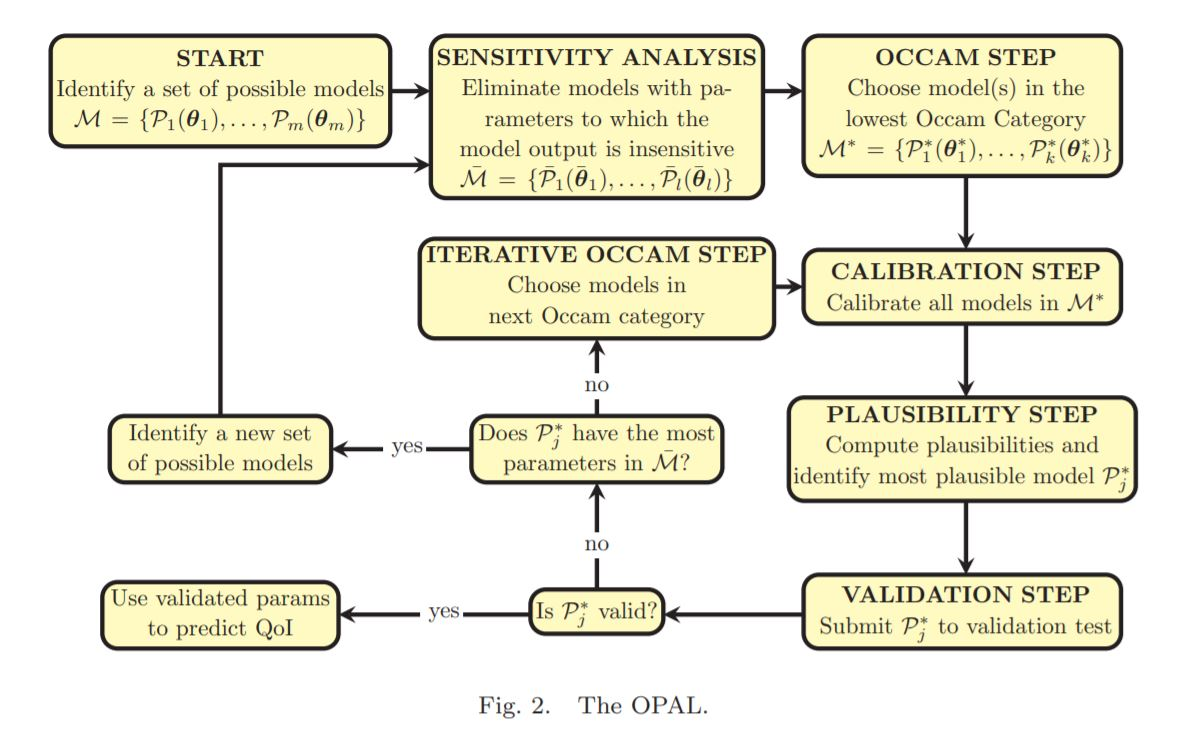

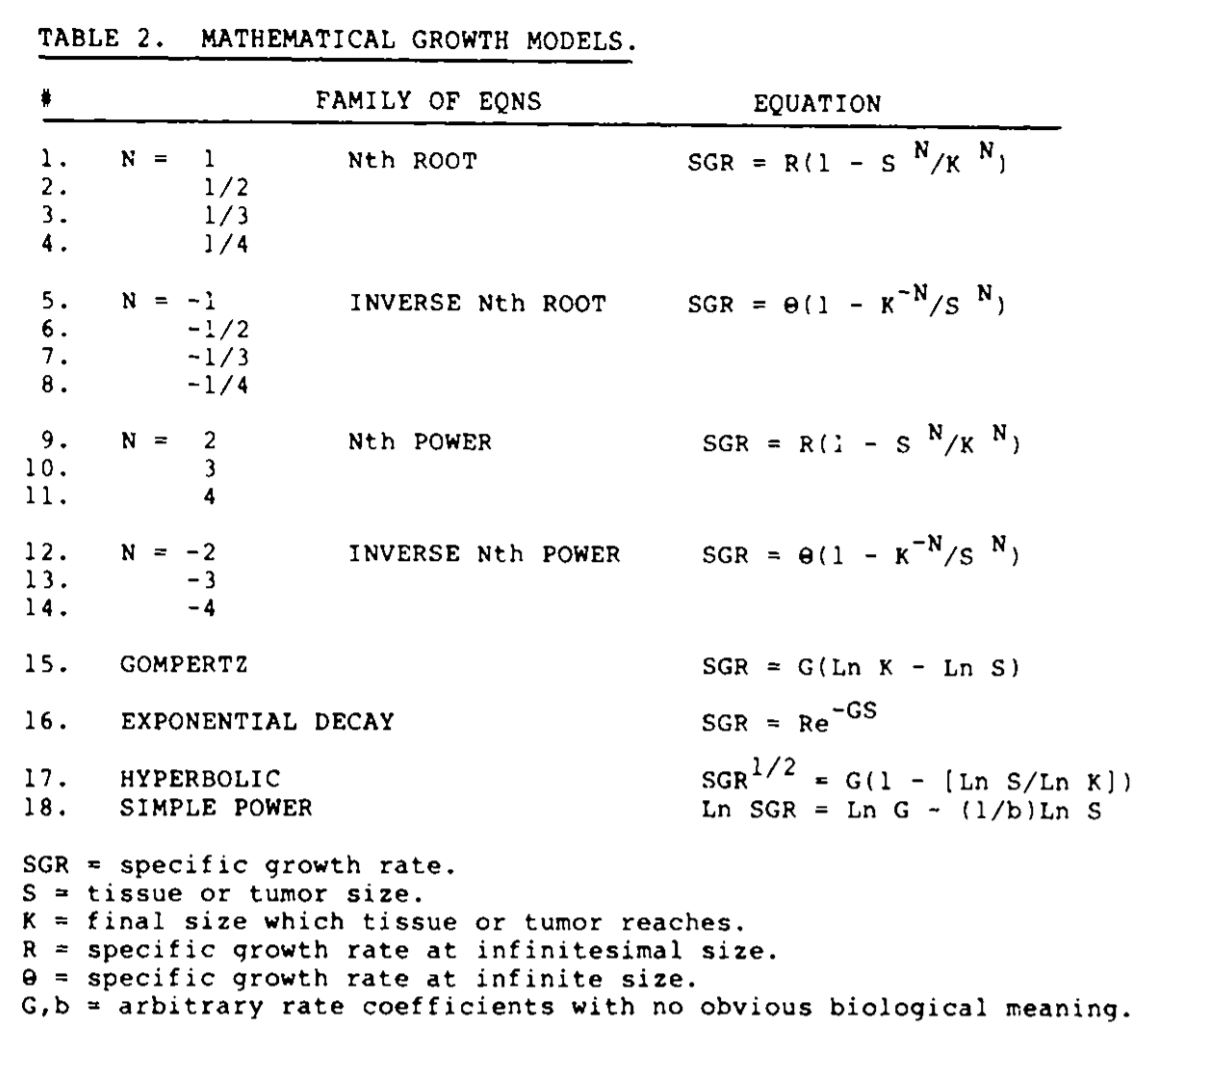

In [1]:
import pandas as pd
import numpy as np
print(np.__version__)
import theano
print(theano.__version__)
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline
import pymc3 as pm
# Initialize random number generator
np.random.seed(123)

import os


1.16.4
1.0.4


In [24]:
dirname = os.getcwd()
#print(dirname)
filename = dirname + '\..\data\\tumor_size_db.csv'
#print(filename)

tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()

tumor_size_db.shape
#tumor_size_db['Day']
#tumor_size_db['G1_avg']

(19, 7)

In [25]:
#forward model
def rungeKutta(ts, y0, dydt): 

    ys = np.zeros((len(ts),len(y0)))
    ys[0] = y0
    y = y0
    
    for i in range(1,(len(ts))) :
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dydt(t0, y) 
        k2 = h * dydt(t0 + 0.5 * h, y + 0.5 * k1) 
        k3 = h * dydt(t0 + 0.5 * h, y + 0.5 * k2) 
        k4 = h * dydt(t0 + h, y + k3) 
  
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        ys[i] = y
   
    return ys

# MCMC

mcmc_model_exponential = pm.Model()

with mcmc_model_exponential:
    # Differential equation
    # 
    # Priors 
    c0 = pm.Uniform('c0', lower=0, upper=5)
    c1 = pm.Uniform('c1', lower=0, upper=5)
    sigma= pm.HalfNormal('sigma', sigma = 1)
    
    #expected outcome of variable
    mu = c0*math.exp(c1*ts)
    
    #Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=ys)
    
with mcmc_model_exponential:
    trace = pm.sample(100, chains=2)

out_array = trace['c0','c1'].reshape(-1,2)
plt.plot(range(out_array.shape[0]),out_array[0])
plt.show()
plt.plot(range(out_array.shape[1]),out_array[1])
plt.show()


In [61]:
class Model:
    def __init__(self, data, params):
        self.data = data
        self.params = params
        
    def occam_category(self):
        return len(self.params)
    
    #def calibrate(self):
    #    return
        
    #def predict(self):
     #   return
        
    def validate(self):
        return 

class exp_Model(Model):
    
    def rungeKutta(self,ts, y0, dydt): 
        ys = np.zeros((len(ts),len(y0)))
        ys[0] = y0
        y = y0

        for i in range(1,(len(ts))) :
            t0 = ts[i-1]
            t = ts[i]
            h = t-t0 
            #print(t0)
            #print(y)
            #print(h)
            k1 = h * dydt(t0, y) 
            k2 = h * dydt(t0 + 0.5 * h, y + 0.5 * k1) 
            k3 = h * dydt(t0 + 0.5 * h, y + 0.5 * k2) 
            k4 = h * dydt(t0 + h, y + k3) 

            # Update next value of y 
            y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
            ys[i] = y

        return ys
    
    def forward(self):
        print('calling forward')
        ts = np.linspace(7,69,62)
        y0 = [self.data['G1_avg'][0]]
        full_predict = self.rungeKutta(ts, y0, self.dydt)
        print(len(full_predict))
        self.predict = full_predict[self.data['Day']-7]
        #print(self.predict)
    
    def backward(self):
        # MCMC

        mcmc_model_exponential = pm.Model()
        
        with mcmc_model_exponential:
            # Differential equation
            # dydt = c1*y
            # Priors 
            #c0 = pm.Uniform('c0', lower=30, upper=36)
            c1 = pm.Uniform('c1', lower=0.04, upper=0.06)
            sigma= pm.HalfNormal('sigma', sigma = 2)# sigma should be a vector in time
            
            #expected outcome of variable
            #mu = c0*np.exp(c1*ts)
            print(type(c1))
            self.params[1] = c1
            self.forward()
            mu = self.predict

            #Likelihood (sampling distribution) of observations
            y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=ys)

        with mcmc_model_exponential:
            trace = pm.sample(1000, chains=5, cores=1, tune=400)

        #c0_out = trace['c0'].reshape(-1,1)
        #plt.plot(range(c0_out.shape[0]),c0_out)
        #plt.show()
        
        c1_out = trace['c1'].reshape(-1,1)
        plt.plot(range(c1_out.shape[0]),c1_out)
        plt.show()
        
        #self.params[0] = np.sum(c0_out[-5:])/5 
        self.params[1] = np.sum(c1_out[-5:])/5
        
        
        #return c0_out, c1_out
        return c1_out
        
    def dydt(self, t, y):
        #return self.params[0]*self.params[1]*math.exp(self.params[1]*t)
        return self.params[1]*y[0]
        
    
    


calling forward
62


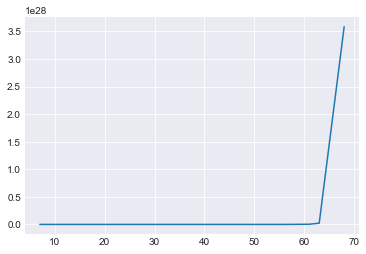

In [62]:

params = np.array([1,1])
this_exp_model = exp_Model(tumor_size_db, params)

this_exp_model.forward()

plt.plot(this_exp_model.data['Day'], this_exp_model.predict)
plt.show()

In [63]:
this_exp_model.backward()

<class 'pymc3.model.TransformedRV'>


ValueError: setting an array element with a sequence.

30.738848865977616
0.05779875628437628


ValueError: x and y must be the same size

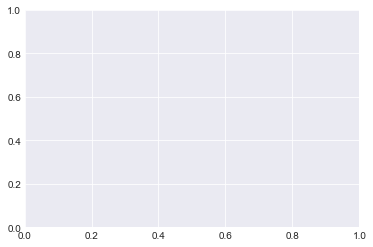

In [20]:
c0_avg = np.average(c0[-50:])
c1_avg = np.average(c1[-50:])
print(c0_avg)
print(c1_avg)
#ts = np.array(this_exp_model.data['Day'])
G1_avg = np.array(this_exp_model.data['G1_avg'])
plt.scatter(ts, G1_avg)

#predict = c0_avg*np.exp(c1_avg*ts)
#ts, predict = this_exp_model.forward()
ts = np.linspace(7,68,61)


predict = rungeKutta(ts, this_exp_model.data['G1_avg'][0], this_exp_model.dydt)

plt.plot(ts, predict)
plt.show()

In [13]:
this_exp_model.params

array([30,  0])

In [64]:
params = [1,2,3,4]
a, b, c, d = [x for x in params]

print(a)
print(b)

1
2
